In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from imutils import paths
import os

from zipfile import ZipFile
file_name = './data.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
# %rm -rf data

In [2]:
# Membuat folder untuk training dan testing dataset
try:
    os.mkdir('./data/training')
    os.mkdir('./data/testing')
    os.mkdir('./data/training/with_mask')
    os.mkdir('./data/training/without_mask')
    os.mkdir('./data/testing/with_mask')
    os.mkdir('./data/testing/without_mask')

except OSError:
    pass

In [3]:
# Memisahkan dan membagi data training dan data testing pada tiap-tiap label, serta membagi nya menjadi 80% data training dan 20% data testing
import random
import shutil
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " Jika kosong, Abaikan.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

MASK_SOURCE_DIR = "./data/with_mask/"
TRAINING_MASK_DIR = "./data/training/with_mask/"
TESTING_MASK_DIR = "./data/testing/with_mask/"

WITHOUT_SOURCE_DIR = "./data/without_mask/"
TRAINING_WITHOUT_DIR = "./data/training/without_mask/"
TESTING_WITHOUT_DIR = "./data/testing/without_mask/"

split_size = .8
split_data(MASK_SOURCE_DIR, TRAINING_MASK_DIR, TESTING_MASK_DIR, split_size)
split_data(WITHOUT_SOURCE_DIR, TRAINING_WITHOUT_DIR, TESTING_WITHOUT_DIR, split_size)

In [4]:
# Memeriksa hasil split(pembagian)
print(len(os.listdir('./data/training/with_mask/')))
print(len(os.listdir('./data/training/without_mask/')))
print(len(os.listdir('./data/testing/with_mask/')))
print(len(os.listdir('./data/testing/without_mask/')))


1532
1534
383
384


In [10]:
# Inisiasi datagen untuk training dan testing
train_gen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.75, 1),
        shear_range=0.1,
        zoom_range=[0.75, 1],
        horizontal_flip=True,
    )

# except for rescaling, no augmentations are needed for validation and testing generators
validation_gen = ImageDataGenerator(
        rescale=1.0 / 255
    )


# Menyesuaikan data image generator
TRAINING_DIR = './data/training'
train_generator = train_gen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

VALIDATION_DIR = './data/testing'
validation_generator = validation_gen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              target_size=(224, 224))



Found 3066 images belonging to 2 classes.
Found 767 images belonging to 2 classes.


In [11]:
# Load the MobileNetV2 network, ensuring the head FC layer sets are left off

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

baseModel = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [12]:
# Construct the head of the model that will be placed on top of the base model

from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [15]:
# Place the head FC model on top of the base model (this will become the actual model we will train)
from tensorflow.keras.models import Model
model = Model(inputs=baseModel.input, outputs=headModel)


# Loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False


# Initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 15
BATCH_SIZE = 32

# Menggunakan fungsi callback
class panggilCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.99):
            print("\n Proses Training dibatalkan jika sudah mencapai akurasi 99%")
            self.model.stop_training = True

callbacks = panggilCallback()

In [16]:
# Compile the model
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


# Training Model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // BATCH_SIZE,
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/15


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


95/95 - 177s - loss: 0.3506 - accuracy: 0.8932 - val_loss: 0.1647 - val_accuracy: 0.9742
Epoch 2/15
95/95 - 172s - loss: 0.1553 - accuracy: 0.9664 - val_loss: 0.0979 - val_accuracy: 0.9796
Epoch 3/15
95/95 - 181s - loss: 0.1032 - accuracy: 0.9740 - val_loss: 0.0770 - val_accuracy: 0.9769
Epoch 4/15
95/95 - 173s - loss: 0.0859 - accuracy: 0.9779 - val_loss: 0.0631 - val_accuracy: 0.9796
Epoch 5/15
95/95 - 173s - loss: 0.0688 - accuracy: 0.9829 - val_loss: 0.0560 - val_accuracy: 0.9796
Epoch 6/15
95/95 - 172s - loss: 0.0604 - accuracy: 0.9832 - val_loss: 0.0455 - val_accuracy: 0.9878
Epoch 7/15
95/95 - 172s - loss: 0.0534 - accuracy: 0.9852 - val_loss: 0.0445 - val_accuracy: 0.9851
Epoch 8/15
95/95 - 171s - loss: 0.0478 - accuracy: 0.9881 - val_loss: 0.0383 - val_accuracy: 0.9891
Epoch 9/15
95/95 - 173s - loss: 0.0449 - accuracy: 0.9895 - val_loss: 0.0320 - val_accuracy: 0.9905
Epoch 10/15
95/95 - 174s - loss: 0.0407 - accuracy: 0.9878 - val_loss: 0.0320 - val_accuracy: 0.9891
Epoch 11/1

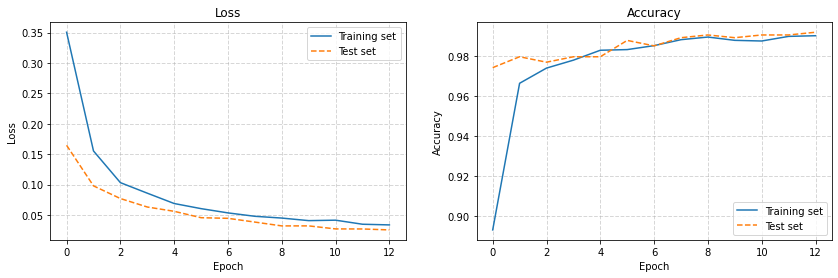

In [17]:
# Melihat hasil akurasi apakah overfitting atau underfitting
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)


plt.show()

In [18]:
# Save the model

MODEL_PATH = "./models/face_mask_detector.h5"
model.save(MODEL_PATH, save_format="h5")

In [20]:
# Export into TensorFlow.js
!pip install tensorflowjs

import tensorflowjs as tfjs

TFJS_MODEL_DIR = "./models/tfjs"
tfjs.converters.save_keras_model(model, TFJS_MODEL_DIR)


     |████████████████████████████████| 71kB 3.4MB/s 
     |████████████████████████████████| 112kB 5.7MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [22]:
!zip -r /content/file.zip ./models

  adding: models/ (stored 0%)
  adding: models/tfjs/ (stored 0%)
  adding: models/tfjs/model.json (deflated 96%)
  adding: models/tfjs/group1-shard1of3.bin (deflated 7%)
  adding: models/tfjs/group1-shard2of3.bin (deflated 7%)
  adding: models/tfjs/group1-shard3of3.bin (deflated 7%)
  adding: models/face_mask_detector.h5 (deflated 10%)


In [24]:
from google.colab import files
files.download("file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>